In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
sns.set()
%matplotlib inline
#sns.set_palette("Set1")
#sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")

# (Section 1) Before neural networks: Logistic regression

## 1.1 The iris dataset

In [2]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


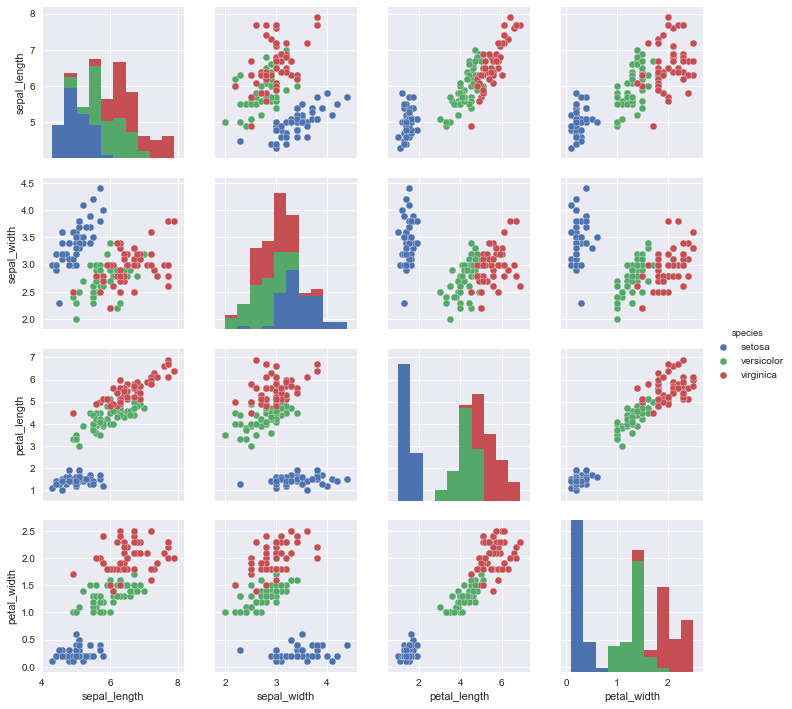

In [10]:
sns.pairplot(iris, hue="species");

### Problem we want to address: knowing the petal width, predict if the iris is a virginica**

# 1.2 Logistic regression

In [51]:
iris['isVirginica'] = (iris['species'] == 'virginica').apply(int)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,isVirginica
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


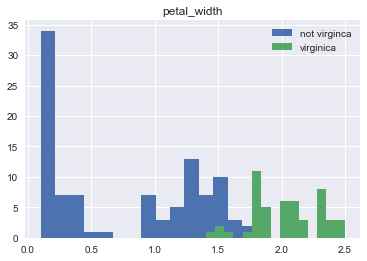

In [52]:
fig, ax = plt.subplots()
iris.groupby('isVirginica').hist(column='petal_width', ax=ax, bins=15);
plt.legend(['not virginca', 'virginica']);

<font size=4>
The **logistic regression** algorithm searches for a function 
$$ P: [0,3] \to [0,1]$$
If $x = $ petal width, $P(x)$ is an estimate (= a guess) of the probability that the plant is a virginica.

The idea of logistic regression is to look for a function of the form:
$$P_{w,b}(x) = \sigma(Wx+B)$$
where 
$$\sigma : \mathbb{R} \to [0,1]$$ is the **sigmoid function ** defined by 
$$ \sigma(x) = \frac{1}{1+e^{-x}}$$
We call $W$ the **weight** and $B$  the **bias**.
</font>

In [53]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

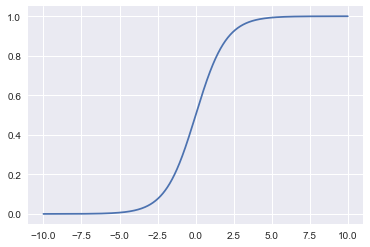

In [54]:
x = np.arange(-10, 10, .01)
plt.plot(x, sigmoid(x));

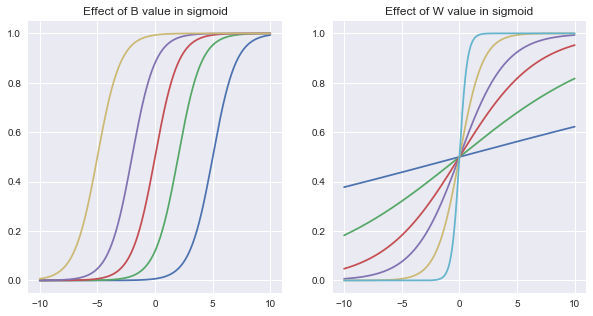

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.set_title('Effect of B value in sigmoid')
for b in [-5, -2, 0, 2, 5]:
    ax1.plot(x, sigmoid(1 * x + b))

ax2.set_title('Effect of W value in sigmoid')
for w in [0.05, .15, .3, .5, 1, 3]:
    ax2.plot(x, sigmoid(w * x + 0))

## 1.3 Scikitlearn

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
model = LogisticRegression()
model.fit(iris[['petal_width']], iris[['isVirginica']])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

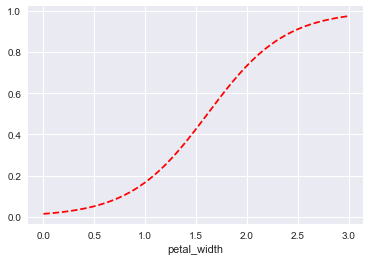

In [58]:
petal_widths = np.arange(0,3,0.01)
predicted_proba = model.predict_proba(petal_widths.reshape(-1,1))[:,1]
plt.plot(petal_widths, predicted_proba, 'r--')
plt.xlabel('petal_width');

1.6200000000000001

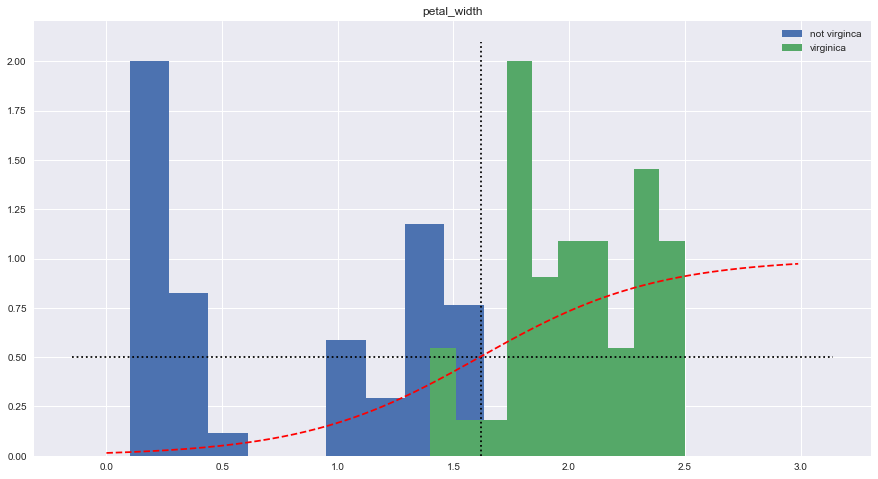

In [70]:
fig, ax = plt.subplots(figsize=(15,8))
iris.groupby('isVirginica').hist(column='petal_width', normed=True, ax=ax);
plt.legend(['not virginca', 'virginica'])
plt.plot(petal_widths, predicted_proba,'r--',label='predicted proba')
plt.hlines(0.5, *ax.get_xlim(), linestyles='dotted')
plt.vlines(petal_widths[np.argmax(predicted_proba > 0.5)], *ax.get_ylim(), linestyles='dotted');
petal_widths[np.argmax(predicted_proba > 0.5)]

<font size=4>
$$ \text{Accuracy} = \frac{\text{number of samples correctly classified}}{\text{total number of samples}}$$
<size>

In [60]:
# with sklearn the method score returns the accuracy
model.score(iris[['petal_width']], iris[['isVirginica']])

0.95999999999999996

### Graphical representation of logistic regression

![logistic regression](../reports/figures/01-log.png)

# 1.4 Keras

In [61]:
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import SVG

In [76]:
model_keras = Sequential([
    Dense(1, input_dim=1),
    Activation('sigmoid'),
])


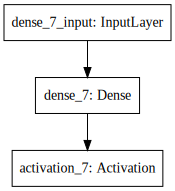

In [77]:
SVG(model_to_dot(model_keras).create(prog='dot', format='svg'))

In [78]:
model_keras.compile(optimizer='sgd', 
                    metrics=['accuracy'],
                    loss='binary_crossentropy')

In [80]:
model_keras.fit(iris[['petal_width']], iris[['isVirginica']], epochs=500)

Epoch 1/500
150/150 [==============================] - 0s 53us/step - loss: 0.2962 - acc: 0.9600
Epoch 2/500
150/150 [==============================] - 0s 51us/step - loss: 0.2961 - acc: 0.9600
Epoch 3/500
150/150 [==============================] - 0s 54us/step - loss: 0.2961 - acc: 0.9600
Epoch 4/500
150/150 [==============================] - 0s 54us/step - loss: 0.2960 - acc: 0.9600
Epoch 5/500
150/150 [==============================] - 0s 54us/step - loss: 0.2959 - acc: 0.9600
Epoch 6/500
150/150 [==============================] - 0s 47us/step - loss: 0.2958 - acc: 0.9600
Epoch 7/500
150/150 [==============================] - 0s 55us/step - loss: 0.2957 - acc: 0.9600
Epoch 8/500
150/150 [==============================] - 0s 48us/step - loss: 0.2956 - acc: 0.9600
Epoch 9/500
150/150 [==============================] - 0s 50us/step - loss: 0.2955 - acc: 0.9600
Epoch 10/500
150/150 [==============================] - 0s 55us/step - loss: 0.2954 - acc: 0.9600
Epoch 11/500
150/150 [=======

150/150 [==============================] - 0s 59us/step - loss: 0.2888 - acc: 0.9600
Epoch 84/500
150/150 [==============================] - 0s 65us/step - loss: 0.2888 - acc: 0.9600
Epoch 85/500
150/150 [==============================] - 0s 47us/step - loss: 0.2886 - acc: 0.9600
Epoch 86/500
150/150 [==============================] - 0s 56us/step - loss: 0.2886 - acc: 0.9600
Epoch 87/500
150/150 [==============================] - 0s 59us/step - loss: 0.2885 - acc: 0.9600
Epoch 88/500
150/150 [==============================] - 0s 47us/step - loss: 0.2884 - acc: 0.9600
Epoch 89/500
150/150 [==============================] - 0s 53us/step - loss: 0.2883 - acc: 0.9600
Epoch 90/500
150/150 [==============================] - 0s 54us/step - loss: 0.2882 - acc: 0.9600
Epoch 91/500
150/150 [==============================] - 0s 62us/step - loss: 0.2881 - acc: 0.9600
Epoch 92/500
150/150 [==============================] - 0s 57us/step - loss: 0.2880 - acc: 0.9600
Epoch 93/500
150/150 [===========

150/150 [==============================] - 0s 60us/step - loss: 0.2822 - acc: 0.9600
Epoch 165/500
150/150 [==============================] - 0s 69us/step - loss: 0.2821 - acc: 0.9600
Epoch 166/500
150/150 [==============================] - 0s 60us/step - loss: 0.2820 - acc: 0.9600
Epoch 167/500
150/150 [==============================] - 0s 56us/step - loss: 0.2820 - acc: 0.9600
Epoch 168/500
150/150 [==============================] - 0s 56us/step - loss: 0.2819 - acc: 0.9600
Epoch 169/500
150/150 [==============================] - 0s 63us/step - loss: 0.2818 - acc: 0.9600
Epoch 170/500
150/150 [==============================] - 0s 49us/step - loss: 0.2817 - acc: 0.9600
Epoch 171/500
150/150 [==============================] - 0s 64us/step - loss: 0.2816 - acc: 0.9600
Epoch 172/500
150/150 [==============================] - 0s 61us/step - loss: 0.2816 - acc: 0.9600
Epoch 173/500
150/150 [==============================] - 0s 54us/step - loss: 0.2816 - acc: 0.9600
Epoch 174/500
150/150 [=

150/150 [==============================] - 0s 44us/step - loss: 0.2762 - acc: 0.9600
Epoch 247/500
150/150 [==============================] - 0s 58us/step - loss: 0.2761 - acc: 0.9600
Epoch 248/500
150/150 [==============================] - 0s 63us/step - loss: 0.2760 - acc: 0.9600
Epoch 249/500
150/150 [==============================] - 0s 53us/step - loss: 0.2761 - acc: 0.9600
Epoch 250/500
150/150 [==============================] - 0s 55us/step - loss: 0.2759 - acc: 0.9600
Epoch 251/500
150/150 [==============================] - 0s 57us/step - loss: 0.2758 - acc: 0.9600
Epoch 252/500
150/150 [==============================] - 0s 55us/step - loss: 0.2757 - acc: 0.9600
Epoch 253/500
150/150 [==============================] - 0s 53us/step - loss: 0.2757 - acc: 0.9600
Epoch 254/500
150/150 [==============================] - 0s 55us/step - loss: 0.2756 - acc: 0.9600
Epoch 255/500
150/150 [==============================] - 0s 56us/step - loss: 0.2755 - acc: 0.9600
Epoch 256/500
150/150 [=

150/150 [==============================] - ETA: 0s - loss: 0.1999 - acc: 1.000 - 0s 50us/step - loss: 0.2706 - acc: 0.9600
Epoch 329/500
150/150 [==============================] - 0s 51us/step - loss: 0.2706 - acc: 0.9600
Epoch 330/500
150/150 [==============================] - 0s 70us/step - loss: 0.2705 - acc: 0.9600
Epoch 331/500
150/150 [==============================] - 0s 45us/step - loss: 0.2704 - acc: 0.9600
Epoch 332/500
150/150 [==============================] - 0s 51us/step - loss: 0.2703 - acc: 0.9600
Epoch 333/500
150/150 [==============================] - 0s 56us/step - loss: 0.2703 - acc: 0.9600
Epoch 334/500
150/150 [==============================] - 0s 57us/step - loss: 0.2702 - acc: 0.9600
Epoch 335/500
150/150 [==============================] - 0s 58us/step - loss: 0.2702 - acc: 0.9600
Epoch 336/500
150/150 [==============================] - 0s 62us/step - loss: 0.2701 - acc: 0.9600
Epoch 337/500
150/150 [==============================] - 0s 49us/step - loss: 0.2700 

Epoch 410/500
150/150 [==============================] - 0s 55us/step - loss: 0.2655 - acc: 0.9600
Epoch 411/500
150/150 [==============================] - 0s 50us/step - loss: 0.2655 - acc: 0.9600
Epoch 412/500
150/150 [==============================] - 0s 53us/step - loss: 0.2654 - acc: 0.9600
Epoch 413/500
150/150 [==============================] - 0s 56us/step - loss: 0.2653 - acc: 0.9600
Epoch 414/500
150/150 [==============================] - 0s 52us/step - loss: 0.2653 - acc: 0.9600
Epoch 415/500
150/150 [==============================] - 0s 53us/step - loss: 0.2652 - acc: 0.9600
Epoch 416/500
150/150 [==============================] - 0s 55us/step - loss: 0.2652 - acc: 0.9600
Epoch 417/500
150/150 [==============================] - 0s 53us/step - loss: 0.2651 - acc: 0.9600
Epoch 418/500
150/150 [==============================] - 0s 59us/step - loss: 0.2650 - acc: 0.9600
Epoch 419/500
150/150 [==============================] - 0s 65us/step - loss: 0.2650 - acc: 0.9600
Epoch 420/

Epoch 492/500
150/150 [==============================] - 0s 49us/step - loss: 0.2609 - acc: 0.9600
Epoch 493/500
150/150 [==============================] - 0s 54us/step - loss: 0.2608 - acc: 0.9600
Epoch 494/500
150/150 [==============================] - 0s 60us/step - loss: 0.2607 - acc: 0.9600
Epoch 495/500
150/150 [==============================] - 0s 56us/step - loss: 0.2607 - acc: 0.9600
Epoch 496/500
150/150 [==============================] - 0s 56us/step - loss: 0.2606 - acc: 0.9600
Epoch 497/500
150/150 [==============================] - 0s 53us/step - loss: 0.2606 - acc: 0.9600
Epoch 498/500
150/150 [==============================] - 0s 65us/step - loss: 0.2605 - acc: 0.9600
Epoch 499/500
150/150 [==============================] - 0s 60us/step - loss: 0.2605 - acc: 0.9600
Epoch 500/500
150/150 [==============================] - 0s 76us/step - loss: 0.2604 - acc: 0.9600


In [82]:
model_keras.metrics_names

['loss', 'acc']

In [83]:
model_keras.evaluate(iris[['petal_width']], iris[['isVirginica']])

150/150 [==============================] - 0s 29us/step


[0.26037017385164896, 0.9600000015894572]

In [84]:
model_keras.get_weights()

[array([[ 2.62836337]], dtype=float32), array([-4.23753881], dtype=float32)]

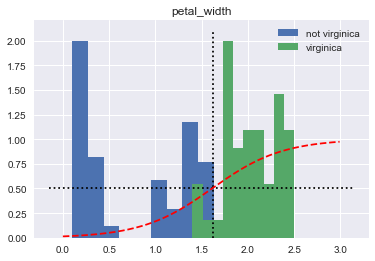

In [85]:
fig, ax = plt.subplots()
iris.groupby('isVirginica').hist(column='petal_width', normed=True, ax=ax);
plt.legend(['not virginica', 'virginica'])
predicted_proba = model_keras.predict(petal_widths.reshape(-1,1))[:,0]
plt.plot(petal_widths, predicted_proba,'r--',label='proba')
plt.hlines(0.5, *ax.get_xlim(), linestyles='dotted')
plt.vlines(petal_widths[np.argmax(predicted_proba > 0.5)], *ax.get_ylim(), linestyles='dotted')

# (Section 2) Gradient descent

# Optimization, gradient descent with Keras

In [87]:
model = Sequential([
    Dense(1,input_dim=1,kernel_regularizer=regularizers.l2(.1)),
    Activation('sigmoid'),
])
model.compile(optimizer=optimizers.SGD(lr=0.05), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
# def get_meshgrid(xstart,xend,xstep,ystart,yend,ystep):
#     xx,yy = np.mgrid[xstart:xend:xstep,ystart:yend:ystep]
#     return xx,yy
# x_grid, y_grid = get_meshgrid(-10,10,.1,-10,10,.1)

In [96]:
x_grid, y_grid = np.mgrid[-10:10:.1,-10:10:.1]

In [24]:
#model.evaluate(x,y)

## Plot accuracy

In [25]:
def get_accuracy(model,weight,bias,x,y,C=1.):
    """Compute the accuracy function."""
    layer =  model.layers[0]
    layer.set_weights( [ np.array([[weight]]) , np.array([bias]) ] ) 
    accuracy = model.evaluate(x,y,verbose=0)[1]
    return accuracy

def get_accuracy1(weigth,bias):
    return get_accuracy(model,weigth,bias,x,y,1.)

vaccuracy = np.vectorize(get_accuracy1)

In [92]:
def get_accuracy(weight,bias):
    """Compute the accuracy function."""
    layer =  model.layers[0]
    layer.set_weights( [ np.array([[weight]]) , np.array([bias]) ] ) 
    accuracy = model.evaluate(iris[['petal_width']], iris[['isVirginica']],verbose=0)[1]
    return accuracy

vaccuracy = np.vectorize(get_accuracy)

In [97]:
#takes two minutes to run
acc_grid = vaccuracy(x_grid,y_grid)

In [27]:
# import pickle
# with open('../data/acc_grid', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(acc_grid, f)

In [28]:
import pickle
with open('../data/acc_grid', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    acc_grid =pickle.load(f)

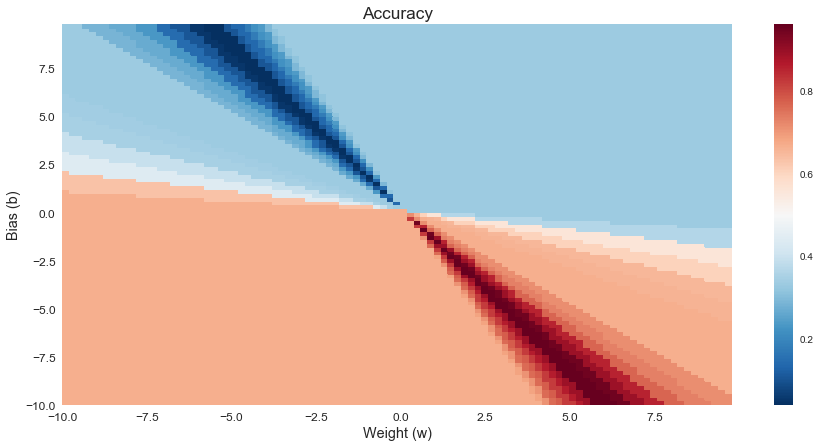

In [98]:
fig,ax_acc = plt.subplots(figsize=(15,7))
plt.pcolor(x_grid , y_grid , acc_grid , cmap='RdBu_r')
plt.colorbar()
plt.title('Accuracy',fontsize='xx-large')
plt.xlabel('Weight (w)',fontsize='x-large')
plt.ylabel('Bias (b)',fontsize='x-large')
ax_acc.tick_params(labelsize='large')

There are so many zones where the accuracy are the same that it is impossible to find a method that would improve the weights step by step.

To overcome this problem, we introduce a new metric: the cross entropy which we call our loss function.

## The cross entropy  loss function

Let us fix $w$ and $b$. We define 
$$\mathcal{L}(p,y) = y \log(p) + (1-y)\log(1-p)$$
$$\mathcal{L_{w,b}} = \sum_{i=1}^n y_i \log(p_i) + (1-y_i)\log(1-p_i)$$
where $y_i\in \{0,1\}$ is the actual classe of the i-th sample and $p_i \in [0,1]$ is the probability $P_{w,b}(x_i)$ calculated by the logistic regression model for parameter values $w$ and $b$.

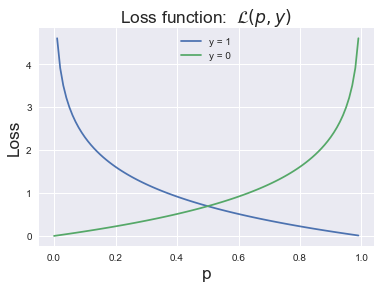

In [31]:
pp = np.arange(0,1,.01)
loss1 = - np.log(pp)
loss0 = -np.log(1-pp)
plt.plot(pp,loss1,label='y = 1')
plt.plot(pp,loss0,label='y = 0')
plt.xlabel('p',fontsize='xx-large')
plt.ylabel('Loss',fontsize='xx-large')
plt.title('Loss function:  $\mathcal{L}(p,y)$',fontsize='xx-large')
_=plt.legend()

In [32]:
def initialise_keras_model(initial_weight = 9,initial_bias = 9,lr=0.05,reg=.1):
    model = Sequential()
    model.add(Dense(1,input_dim=1,kernel_regularizer=regularizers.l2(.1)))
    model.add(Activation('sigmoid'))
    sgd = optimizers.SGD(lr=lr)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    layer =  model.layers[0]
    layer.set_weights( [ np.array([[initial_weight]]) , np.array([initial_bias]) ] ) 
    return model

In [33]:
def get_loss(model,weight,bias,x,y,C=1.):
    """Compute the loss function."""
    layer =  model.layers[0]
    layer.set_weights( [ np.array([[weight]]) , np.array([bias]) ] ) 
    loss = model.evaluate(x,y,verbose=0)[0]
    return loss

def get_loss1(weigth,bias):
    return get_loss(model,weigth,bias,x,y,1.)

vloss = np.vectorize(get_loss1)

In [ ]:
#loss_grid = vloss(x_grid,y_grid)

In [ ]:
# import pickle
# with open('../data/loss_grid', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(loss_grid, f)

In [34]:
import pickle
with open('../data/loss_grid', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    loss_grid =pickle.load(f)

NameError: name 'y' is not defined

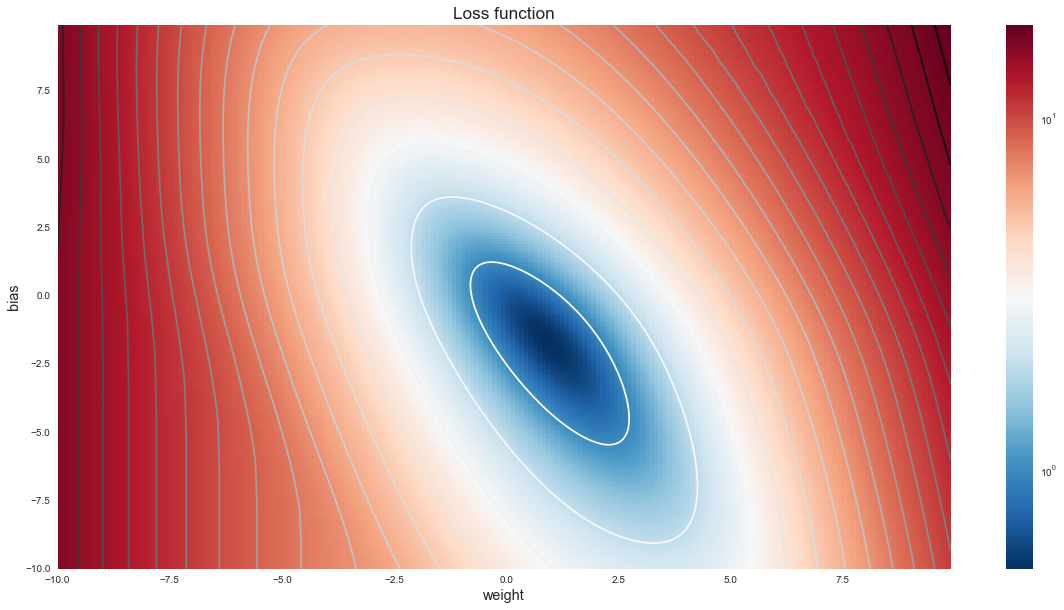

In [35]:
fig , ax_loss = plt.subplots(figsize=(20,10))
plt.pcolor(x_grid , y_grid , loss_grid , norm=colors.LogNorm() , cmap='RdBu_r')
plt.colorbar()
contour = plt.contour(x_grid, y_grid, loss_grid,20)
plt.title('Loss function',fontsize='xx-large')
plt.xlabel('weight',fontsize='x-large')
plt.ylabel('bias',fontsize='x-large')

model = initialise_keras_model(reg=.05)
steps = 15
for i in range(steps):
    old_weight, old_bias = model.get_weights()[0][0][0], model.get_weights()[1][0]
    model.fit(x,y,verbose=0,epochs = 8)
    weight, bias = model.get_weights()[0][0][0], model.get_weights()[1][0]
    plt.plot([old_weight,weight],[old_bias,bias],'kX--',markersize=8)

# (Section 3) Neural Networks: when linear methods are not sufficient

In [ ]:
plot_histogram('versicolor','petal_width')

## Goal: determine if an iris is a versicolor knowing its petal width

## First let's try using logistic regression

In [ ]:
x = iris.petal_width
y = iris.species.apply(lambda x: 1 if x=='versicolor' else 0)
x_train, x_test, y_train, y_test = \
sklearn.model_selection.train_test_split(x,y,test_size = 0.2,random_state=0)

In [ ]:
model_versicolor = Sequential()
model_versicolor.add(Dense(1, input_dim=1 , kernel_regularizer=regularizers.l2(.1)))
model_versicolor.add(Activation('sigmoid'))
model_versicolor.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_versicolor.fit(x_train,y_train,epochs=1000)

In [ ]:
plot_histogram('versicolor','petal_width',normed=True)
petal_widths = np.arange(0,3,0.01)
probas = model_versicolor.predict(petal_widths.reshape(-1,1))[:,0]
plt.plot(petal_widths,probas,'r--',label='proba')
plt.plot([0,3],[.5,.5],'k--',linewidth=1,label = 'proba = 0.5')
plt.legend()
plt.yticks([0,0.5,1]);

## Now let's add a new layer to the neural network

![NN](../reports/figures/01-hidden.png)

In [ ]:
def initialize_versicolor_model(lr = .1,h=5):
    model = Sequential()
    model.add(Dense(h, input_dim=1 ) )
    model.add(Activation('sigmoid'))
    model.add(Dense(1, input_dim=1 ) )
    model.add(Activation('sigmoid'))
    sgd = optimizers.SGD(lr=lr)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_versicolor = initialize_versicolor_model()

In [ ]:
n_rows = n_cols = 3
plt.subplots(n_rows,n_cols,figsize=(18,15),sharex=True,sharey=True)
epochs=200
petal_widths = np.arange(0,3,0.01)
for i in range(1,n_rows**2+1):
    plt.subplot(n_rows,n_cols, i)
    model_versicolor.fit(x_train,y_train,epochs=epochs,verbose=0)
    probas = model_versicolor.predict(petal_widths.reshape(-1,1))[:,0]
    plt.plot(petal_widths,probas,label='after  {} epochs'.format(i*epochs))
    plt.ylim((0,1))
    plt.legend(fontsize='large')

In [ ]:
plot_histogram('versicolor','petal_width',normed=True)
probas = model_versicolor.predict(petal_widths.reshape(-1,1))[:,0]
plt.plot(petal_widths,probas,'b',label='after  {} epochs'.format(i));